##Hyperparameters for the model:

In [1]:
iterations = 50 #Number of teacher-student switching
eps = 1 #number of updates per teaching moment
lr = 0.005 #how fast we learn
hidden_feat_num = 20
reps =  25 #Number of repetitions of the full simulation
vocab_size = 100

my_dir = "/content/gdrive/My Drive/NN_Stress/Output_Files_AgentBased"

#Dictionary that maps from feature values in the SR to segments:
#Features that just have stress in output:
feats2symbol_sr = {
                      "1":"L",
                      "-1":"R"
                  }

##Import the necessary packages:

In [3]:
import numpy as np
from re import sub, search, findall
import keras
from tensorflow.keras import backend
from random import choice, shuffle, randint
from itertools import product
from matplotlib.pyplot import plot, legend, show, xlabel, ylabel, title, ylim
from IPython.display import clear_output
import os
from os import listdir
from pathlib import Path
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
#Features for the input (binary phonological feats, with -1 and 1 being - and +, resp.):
symbol2feats_ur = {
                  #Non-Empty  syll labial  velar voice high  front low
              "p":[1,         -1,  1,      -1,    -1,   -1,    -1,    -1],
              "b":[1,         -1,  1,      -1,    1,    -1,    -1,   -1],
              "t":[1,         -1,  -1,      -1,    -1,    -1,    -1,    -1],
              "d":[1,         -1,  -1,      -1,    1,    -1,    -1,    -1],
              "k":[1,         -1,  -1,      1,   -1,    -1,    -1,    -1],
              "g":[1,         -1,  -1,      1,    1,    -1,    -1,    -1],
              "a":[1,         1,  -1,      -1,    1,    -1,    -1,    1],
              "i":[1,         1,  -1,      -1,    1,    1,    1,    -1],
              "e":[1,         1,  -1,      -1,    1,    -1,    1,    -1],
              "o":[1,         1,  -1,      -1,    1,    -1,    -1,    -1],
              "u":[1,         1,  -1,      -1,    1,    1,    -1,    -1],
              "E":[-1,        -1,  -1,      -1,   -1,    -1,   -1,    -1]
}

#Features for the output:
feats2symbol_sr = {
                      "1":"L", #left-aligned stress
                      "-1":"R", #right-aligned stress

                  }

##Custom Functions

In [5]:
def get_arrays(UR_strings, syll_lengths, SR_strings=["None"]):
  #Converts sets of strings into the numerical inputs the models need:
  max_len = max(syll_lengths)
  X_list = []

  for word_index, syll_length in enumerate(syll_lengths):
    padding = "E"*(max_len-syll_length)
    this_ur = UR_strings[word_index]+padding
    X_list.append([symbol2feats_ur[seg] for seg in this_ur])

  X = np.array(X_list, dtype='float32')

  return X

def MSE(A, B):
  #Returns the mse of the outputs for each model:
  squared_errors = []
  for a, b in zip(A,B):
    for a_seg, b_seg in zip(a, b):
      for a_feat, b_feat in zip(a_seg, b_seg):
        squared_errors.append((a_feat-b_feat) ** 2)
  return np.mean(squared_errors)

def big_model():
  #This function based on the tutorial at
  #https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

  #Keep track of the number of input and output features we have:
  num_encoder_features = len(list(symbol2feats_ur.values())[0])
  num_decoder_features = len(list(feats2symbol_sr.keys())[0].split(","))

  #Define an input sequence and process it with the encoder:
  encoder_inputs = keras.Input(shape=(None, num_encoder_features))
  encoder1 = keras.layers.LSTM(hidden_feat_num, return_state=True, return_sequences=True)
  encoder2 = keras.layers.LSTM(hidden_feat_num, return_state=True)
  encoder1_outputs, state_h1, state_c1 = encoder1(encoder_inputs)
  encoder2_outputs, state_h2, state_c2 = encoder2(encoder1_outputs)

  #Discard encoder_outputs and only keep the states (recurrent connections):
  encoder1_states = [state_h1, state_c1]
  encoder2_states = [state_h2, state_c2]

  #Set up the decoder, using `encoder_states` as initial state:
  decoder1_inputs = keras.Input(shape=(None, num_decoder_features))

  #Setting up the decoder:
  decoder1_lstm = keras.layers.LSTM(hidden_feat_num, return_sequences=True, return_state=True)
  decoder2_lstm = keras.layers.LSTM(hidden_feat_num, return_sequences=True, return_state=True)
  decoder1_outputs, _, _ = decoder1_lstm(decoder1_inputs, initial_state=encoder1_states)
  decoder2_outputs, _, _ = decoder2_lstm(decoder1_outputs, initial_state=encoder2_states)
  decoder_dense = keras.layers.Dense(num_decoder_features, activation="tanh")

  decoder_outputs = decoder_dense(decoder2_outputs)

  # Define the full model:
  model = keras.Model([encoder_inputs, decoder1_inputs], decoder_outputs)

  return model

def build_data(syll_inventory):
  #This takes an inventory of syllables and returns
  #a randomly built lexicon the size of "vocab_size":
  X_strings = []
  word_lengths = []

  building_train = True
  exit_counter = 0
  while building_train:
    exit_counter += 1
    if exit_counter >= 100000:
      raise Exception("Need bigger training space or smaller vocab size!")

    word_length = choice([1, 2, 3, 4, 5])
    this_word = "".join([choice(syll_inventory) for syll in range(word_length)])
    if this_word in X_strings:
      continue

    if building_train:
      word_lengths.append(len(this_word))
      X_strings.append(this_word)
      if len(X_strings) == vocab_size:
        building_train = False
  return X_strings, word_lengths

##Run simulation

In [6]:
#Make the inputs:
C_inventory = ["p", "b", "t", "d", "k", "g"]
V_inventory = ["a", "i", "e", "o", "u"]

syll_inventory = []
for c in C_inventory:
  for v in V_inventory:
    syll_inventory.append(c+v)

results_dict = {r:{i:{"A":["" for x in range(vocab_size)], "B":["" for x in range(vocab_size)]} for i in range(iterations+1)} for r in range(reps)}
rep2learningCurve = {r:[0.0 for i in range(iterations+1)] for r in range(reps)}
for rep in range(reps):
  print ("Repetition: ", rep)

  #Create data for this repetition:
  X_strings, word_lengths = build_data(syll_inventory)
  X = get_arrays(X_strings, word_lengths)
  Y_dims = [1, len(list(feats2symbol_sr.keys())[0].split(","))]

  #Decoder inputs are randomly produced (only want it looking at recurrent connections):
  decoder_data_A = np.array([[[randint(-100,100)]] for x in X_strings])
  decoder_data_B = np.array([[[randint(-100,100)]] for x in X_strings])

  #Build the models:
  model_A = big_model()
  model_B = big_model()
  opt1 = keras.optimizers.RMSprop(learning_rate=lr)
  opt2 = keras.optimizers.RMSprop(learning_rate=lr)
  model_A.compile(
        optimizer=opt1, loss="mean_squared_error", metrics=["accuracy"]
    )
  model_B.compile(
        optimizer=opt2, loss="mean_squared_error", metrics=["accuracy"]
    )

  #Save the initial results:
  Y_hat_A = model_A.predict([X, decoder_data_A])
  Y_hat_B = model_B.predict([X, decoder_data_B])
  rep2learningCurve[rep][0] = MSE(Y_hat_A, Y_hat_B)

  for i, A_word in enumerate(Y_hat_A):
    B_word = Y_hat_B[i]

    if B_word[0][0] > 0:
      B_string = "L"
    elif B_word[0][0] < 0:
      B_string = "R"
    else:
      raise Exception("Output value = 0!")

    if A_word[0][0] > 0:
      A_string = "L"
    elif A_word[0][0] < 0:
      A_string = "R"
    else:
      raise Exception("Output value = 0!")

    results_dict[rep][0]["A"][i] = A_string
    results_dict[rep][0]["B"][i] = B_string


  #Have the models take turns being teachers:
  for iter in range(iterations):
    print("\tIteration: ", iter, ", ", "Repetition: ", rep)

    print("\t\tModel A teaching Model B...")
    this_Y = model_A.predict([X, decoder_data_A])
    model_B.fit(
          [X, decoder_data_B],
          this_Y,
          batch_size=1,
          epochs=eps,
          validation_split=0.
      )
    Y_hat_B = model_B.predict([X, decoder_data_B])

    print("\t\tModel B teaching Model A...")
    this_Y = model_B.predict([X, decoder_data_B])
    model_A.fit(
          [X, decoder_data_A],
          this_Y,
          batch_size=1,
          epochs=eps,
          validation_split=0.
      )

    #Save the useful info and delete everything else:
    print("\t\tGetting predictions...")
    Y_hat_A = model_A.predict([X, decoder_data_A])

    print("\t\tSaving predictions...")
    rep2learningCurve[rep][iter+1] = MSE(Y_hat_A, Y_hat_B)

    #Filling up "results dict" with the outputs for each model at this point:
    for i, A_word in enumerate(Y_hat_A):
      B_word = Y_hat_B[i]

      #Convert numerical outputs to L (left aligned) or R (right aligned):
      #Model B:
      if B_word[0][0] > 0:
        B_string = "L"
      elif B_word[0][0] < 0:
        B_string = "R"
      else:
        raise Exception("Output value = 0!")

      #Model A:
      if A_word[0][0] > 0:
        A_string = "L"
      elif A_word[0][0] < 0:
        A_string = "R"
      else:
        raise Exception("Output value = 0!")

      results_dict[rep][iter+1]["A"][i] = A_string
      results_dict[rep][iter+1]["B"][i] = B_string


    clear_output()
  backend.clear_session()
  clear_output()

##Plot training data results:

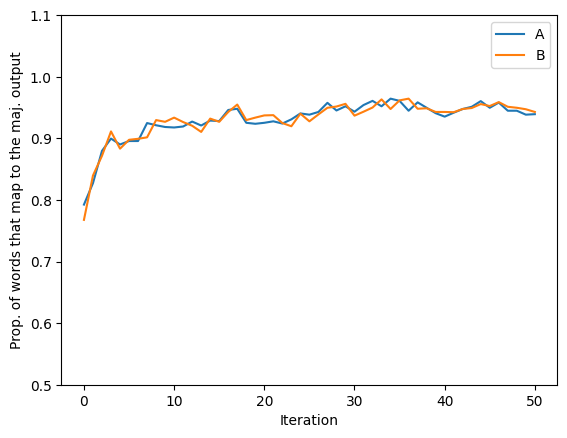

In [7]:
a_proportion_train = []
b_proportion_train = []
a_sd_train = []
b_sd_train = []
a_hist_train = {val:0 for val in range(50,101)}
b_hist_train = {val:0 for val in range(50,101)}

for i in range(iterations+1):
  a_this_iter = []
  b_this_iter = []
  for rep in range(reps):
    a_results_string = ",".join(results_dict[rep][i]["A"])
    b_results_string = ",".join(results_dict[rep][i]["B"])

    #Look at results from Model A, find prop. of maj. outputs:
    a_Lnum = len(findall("L", a_results_string))
    a_Lprop = float(a_Lnum)/float(vocab_size)
    if a_Lprop >= .5:
      a_prop = a_Lprop
    else:
      a_prop = 1.0 - a_Lprop
    a_this_iter.append(a_prop)

    #Look at results from Model B, find prop. of maj. outputs:
    b_Lnum = len(findall("L", b_results_string))
    b_Lprop = float(b_Lnum)/float(vocab_size)
    if b_Lprop >= .5:
      b_prop = b_Lprop
    else:
      b_prop = 1.0 - b_Lprop
    b_this_iter.append(b_prop)

    #Save histogram info at the last iteration:
    if i == iterations:
      if b_Lnum >= 50:
        b_count = b_Lnum
      else:
        b_count = 100-b_Lnum

      b_hist_train[b_count] += 1

      if a_Lnum >= 50:
        a_count = a_Lnum
      else:
        a_count = 100-a_Lnum
      a_hist_train[a_count] += 1

  a_proportion_train.append(np.mean(a_this_iter))
  b_proportion_train.append(np.mean(b_this_iter))
  a_sd_train.append(np.std(a_this_iter))
  b_sd_train.append(np.std(b_this_iter))

#Plot these results:
plot(a_proportion_train, label="A")
plot(b_proportion_train, label="B")
legend()
xlabel("Iteration")
ylabel("Prop. of words that map to the maj. output")
ylim(0.5,1.1)
show()

##Save all results:

In [8]:
#Full output at each learning update:
output_file = open(my_dir+"/Full_Output_NN.csv", "w")
output_file.write("Iteration,Model,DataType,Proportion,SD\n")
for ep, a_train_prop_float in enumerate(a_proportion_train):
  this_a_train_prop = str(a_train_prop_float)
  this_b_train_prop = str(b_proportion_train[ep])

  this_a_train_sd = str(a_sd_train[ep])
  this_b_train_sd = str(b_sd_train[ep])

  output_file.write(",".join([str(ep), "A", "Train", this_a_train_prop, this_a_train_sd])+"\n")
  output_file.write(",".join([str(ep), "B", "Train", this_b_train_prop, this_b_train_sd])+"\n")

output_file.close()

#Histogram info:
hist_file = open(my_dir+"/Histogram_Output_NN.csv", "w")
hist_file.write("Model,Value,DataType,Count\n")
for val in range(50,101):
  hist_file.write(",".join(["A",str(val),"Train",str(a_hist_train[val])])+"\n")
  hist_file.write(",".join(["B",str(val),"Train",str(b_hist_train[val])])+"\n")
hist_file.close()

#Learning curves:
lc_file = open(my_dir+"/LearningCurve_Output_NN.csv", "w")
lc_file.write("Repetition,Iteration,MSE\n")
for r in range(reps):
  for i in range(iterations+1):
    lc_file.write(",".join([str(r),str(i),str(rep2learningCurve[r][i])])+"\n")
lc_file.close()